# Final Capstone Project 

I would classify this project as a social science endeavor on figuring out human behavior regarding booking trends for airbnb's based on historical data. Specifically the objective here of predicting the booking percentage of a given airbnb residence for Austin/Surrounding area in Texas.

In [675]:
#Basic lib imports to view data
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime


In [755]:
#Initialize the data structure that will house our model metrics
model_metric_list = list()

# EDA

This section we will take our data that we wrangled earlier and explore it to find any patters/insights to further help us when modeling for regression. We are going to reference the initial data-set which contained string values and was wrangled into a strictly numeric value dataset.

In [767]:
df_eda = pd.read_csv("listings.csv")
df_eda.shape

(11972, 74)

This portion gave me some insight into the common words that were associated with the Austin properties for the following fields:

* Description
* Name
* Neighborhood
* Property Type

But first let's split the data for the Austin airbnb listing data based on availability

In [768]:
df_eda['percentage_aval_30'] = df_eda['availability_30'] / 30
df_non_optimal_booking = df_eda.loc[df_eda['percentage_aval_30'] >= .5]
df_optimal_booking = df_eda.loc[df_eda['percentage_aval_30'] <= .5]

In [769]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

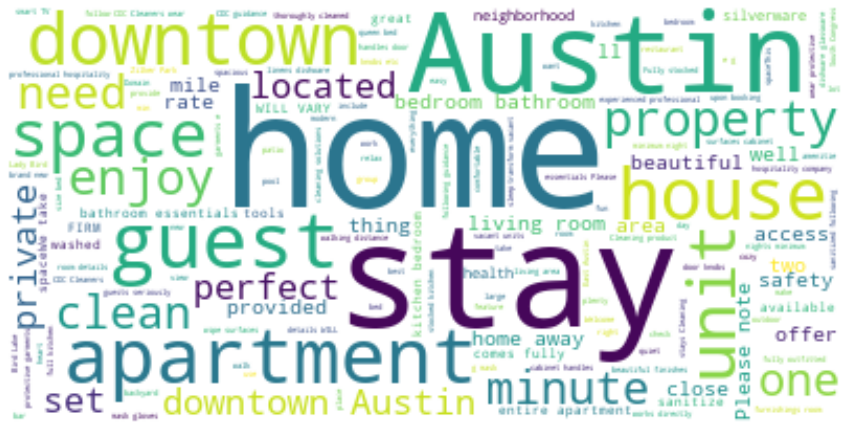

In [770]:
exclude_list = ['<b>', '</b>', '<br />']#exclude special characters
text = " ".join(word for word in df_non_optimal_booking['description'] if not pd.isna(word))
for exclude_char in exclude_list:
    text = text.replace(exclude_char, '')
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

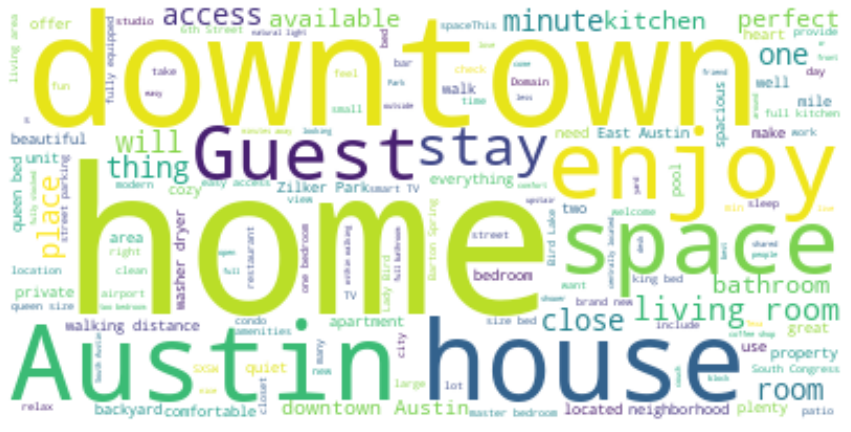

In [771]:
exclude_list = ['<b>', '</b>', '<br />']#exclude special characters
text = " ".join(word for word in df_optimal_booking['description'] if not pd.isna(word))
for exclude_char in exclude_list:
    text = text.replace(exclude_char, '')
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

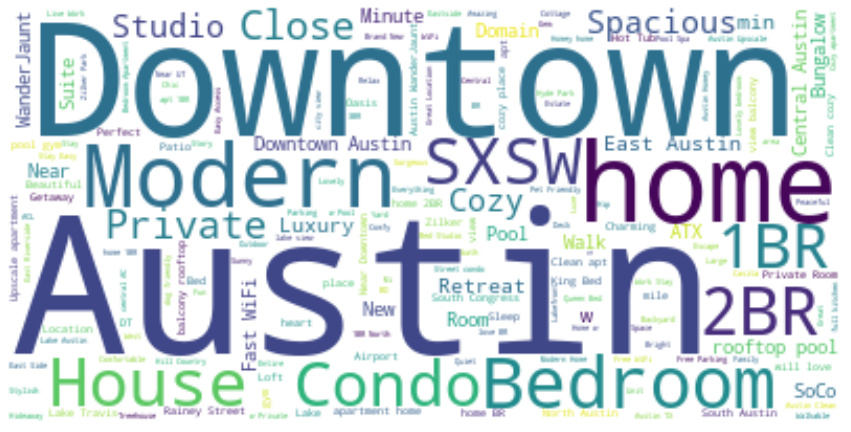

In [772]:
exclude_list = ['<b>', '</b>', '<br />']#exclude special characters
text = " ".join(word for word in df_non_optimal_booking['name'] if not pd.isna(word))
for exclude_char in exclude_list:
    text = text.replace(exclude_char, '')
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

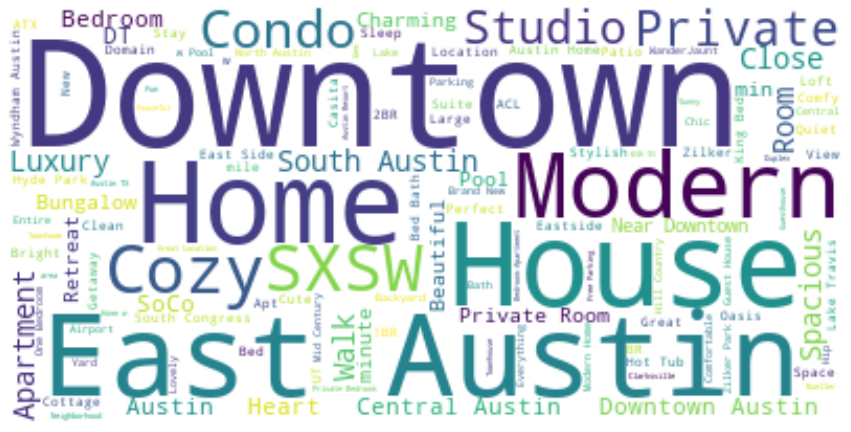

In [773]:
exclude_list = ['<b>', '</b>', '<br />']#exclude special characters
text = " ".join(word for word in df_optimal_booking['name'] if not pd.isna(word))
for exclude_char in exclude_list:
    text = text.replace(exclude_char, '')
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

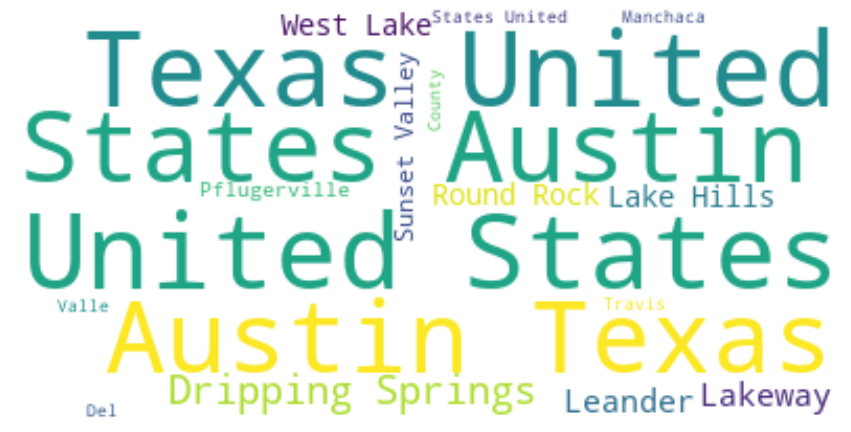

In [774]:
exclude_list = ['<b>', '</b>', '<br />']#exclude special characters
text = " ".join(word for word in df_non_optimal_booking['neighbourhood'] if not pd.isna(word))
for exclude_char in exclude_list:
    text = text.replace(exclude_char, '')
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

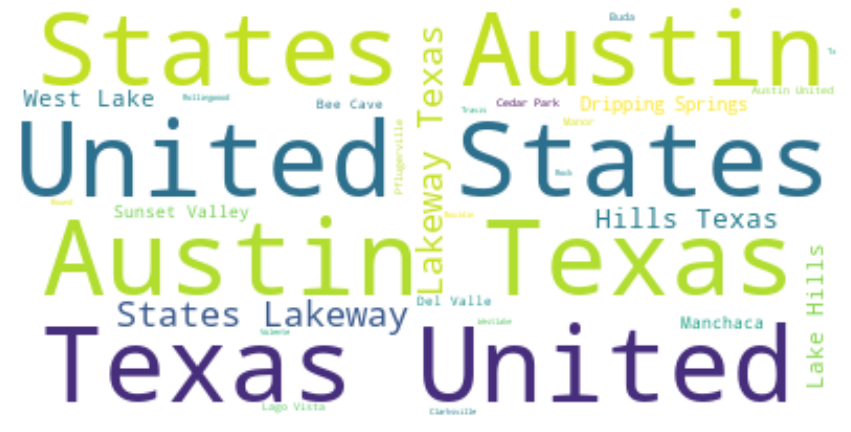

In [775]:
exclude_list = ['<b>', '</b>', '<br />']#exclude special characters
text = " ".join(word for word in df_optimal_booking['neighbourhood'] if not pd.isna(word))
for exclude_char in exclude_list:
    text = text.replace(exclude_char, '')
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

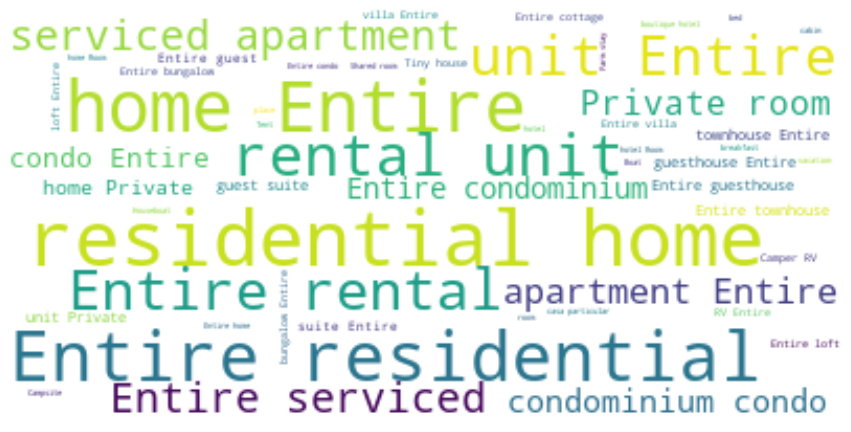

In [776]:
exclude_list = ['<b>', '</b>', '<br />']#exclude special characters
text = " ".join(word for word in df_non_optimal_booking['property_type'] if not pd.isna(word))
for exclude_char in exclude_list:
    text = text.replace(exclude_char, '')
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

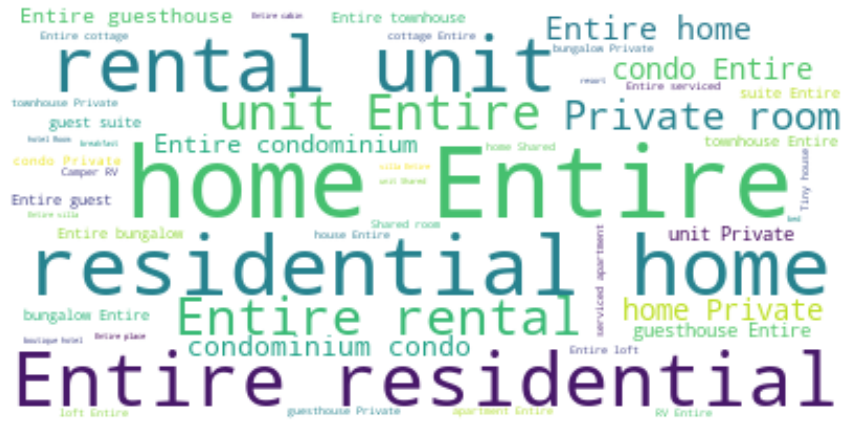

In [777]:
exclude_list = ['<b>', '</b>', '<br />']#exclude special characters
text = " ".join(word for word in df_optimal_booking['property_type'] if not pd.isna(word))
for exclude_char in exclude_list:
    text = text.replace(exclude_char, '')
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Very interesting it appears that even thought these datasets are very much similar (>=50% booking vs <50%) they do differ slightly regarding what are the prevelant property types, neighbourhood and listing name. Location is king and in Austin TX downtown is prime real estate for consistent bookings.

Let's look at the heatmap for our current dataframe (sans string values) to see if we have any strong correlations between features, specifically the independent variables and our target variable.

In [779]:
#Helper function for reading in data and dropping unecessary columns
def get_default_data(file_name):
    df = pd.read_csv(file_name)
    df[['beds', 'bedrooms']] = df[['beds', 'bedrooms']].fillna(1)
    df.drop(columns=['reviews_per_month', 'review_scores_value', 'review_scores_location', 'review_scores_communication', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_rating', 'latitude', 'longitude', 'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm', 'host_total_listings_count'], inplace=True)
    df.dropna(inplace=True)
    return df

In [780]:
#Helper function that allows us to get our X and y dataframe for our models
def default_X_and_y(df):
    X = df.loc[:, ~df.columns.isin(['percentage_aval_30'])]
    y = df['percentage_aval_30']

    return X, y
    

In [781]:
df = get_default_data("modeling_phase.csv") #Read in updated dataframe that has been wrangled
df.head()

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,calculated_host_listings_count,percentage_aval_30,has_shampoo,has_kitchen,has_heating,has_air conditioning,has_smoke alarm,has_essentials,has_iron,has_free parking on premises,has_hangers,has_hair dryer,has_washer,has_long term stays allowed,has_wifi,entire_space,"neighbourhood_Austin , Texas, United States","neighbourhood_Austin, Texas, United States","neighbourhood_Austin, Tx, United States","neighbourhood_Austin, United States","neighbourhood_Bee Cave, Texas, United States","neighbourhood_Bouldin, Austin, Texas, United States","neighbourhood_Buda, Texas, United States","neighbourhood_Cedar Park, Texas, United States","neighbourhood_Clarksville, Texas, United States","neighbourhood_Del Valle, Texas, United States","neighbourhood_Dripping Springs, Texas, United States","neighbourhood_Lago Vista, Texas, United States","neighbourhood_Lake Travis, Texas, United States","neighbourhood_Lakeway, Texas, United States","neighbourhood_Leander, Texas, United States","neighbourhood_Manchaca, Texas, United States","neighbourhood_Manor, Austin, Texas, United States","neighbourhood_Manor, Texas, United States","neighbourhood_Pflugerville, Texas, United States","neighbourhood_Rollingwood, Texas, United States","neighbourhood_Round Rock, Texas, United States","neighbourhood_Sunset Valley, Texas, United States","neighbourhood_The Hills, Texas, United States","neighbourhood_Travis County, Texas, United States",neighbourhood_United States,"neighbourhood_Volente, Texas, United States","neighbourhood_West Lake Hills, Texas, United States","neighbourhood_Westlake Hills, Austin, Texas, United States"
0,1,1.0,1,1,3,1.0,2.0,240.0,2,90,1,585,42,5,0,1,0.233333,1,1,1,1,1,1,1,0,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1.0,1,1,2,1.0,1.0,42.0,1,14,1,264,3,0,0,1,0.000000,1,1,1,1,1,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1.0,1,1,2,1.0,1.0,109.0,3,365,1,117,2,0,1,1,0.000000,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,2.0,1,1,3,1.0,2.0,325.0,3,365,1,268,30,3,1,1,0.300000,1,1,0,0,1,1,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1.0,1,0,2,1.0,1.0,44.0,3,90,1,48,2,0,0,1,0.000000,1,1,1,1,1,1,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [680]:
df.shape

(11968, 59)

<AxesSubplot:>

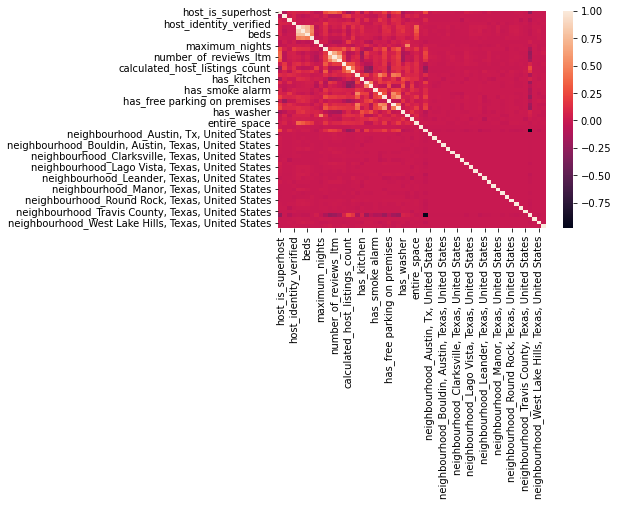

In [782]:
sns.heatmap(df.corr())

Looks to be a lot of weak correlations in our data, however their predictive power may prove useful combined all together when predicting an airbnb booking for the month.

In [784]:
X,y = default_X_and_y(df) #Getting ready to split the data for training purposes

Let's examine our percentage available for 30 days attribute that we created in our preprocessing state, get a feel of the range and variablity of the data.

In [785]:
y.describe()

count    11968.000000
mean         0.277384
std          0.324148
min          0.000000
25%          0.000000
50%          0.133333
75%          0.500000
max          1.000000
Name: percentage_aval_30, dtype: float64

Let's look at the data for our target variable and its distribution of data

<AxesSubplot:>

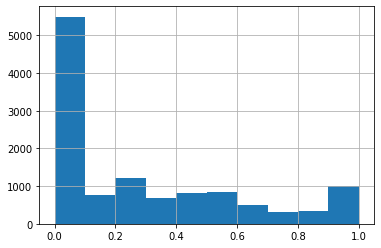

In [786]:
y.hist()

This data looks to be a little inbalanced, perhaps this is naturally ocurring and is not an issue let's revisit this after we take a look at our training model metrics

In [787]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=43)

Standardize (scale) some of the feature output

In [788]:
def scale_fatures(train_df, test_df):
    scale_features = ['number_of_reviews','maximum_nights','minimum_nights','price','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d', 'bedrooms', 'beds', 'host_listings_count']
    for feature in scale_features:
        scaler = StandardScaler()
        #train the scaler based on training data
        df_feat = np.asarray(train_df[feature])
        df_feat = df_feat.reshape(-1, 1)
        train_df[feature] = scaler.fit_transform(df_feat)
        #apply fit data model to test data
        df_feat_test = np.asarray(test_df[feature])
        df_feat_test = df_feat_test.reshape(-1, 1)
        test_df[feature] = scaler.transform(df_feat_test)

    return train_df, test_df

In [789]:
X_train, X_test = scale_fatures(X_train, X_test)

In [790]:
X_train.head()

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,calculated_host_listings_count,has_shampoo,has_kitchen,has_heating,has_air conditioning,has_smoke alarm,has_essentials,has_iron,has_free parking on premises,has_hangers,has_hair dryer,has_washer,has_long term stays allowed,has_wifi,entire_space,"neighbourhood_Austin , Texas, United States","neighbourhood_Austin, Texas, United States","neighbourhood_Austin, Tx, United States","neighbourhood_Austin, United States","neighbourhood_Bee Cave, Texas, United States","neighbourhood_Bouldin, Austin, Texas, United States","neighbourhood_Buda, Texas, United States","neighbourhood_Cedar Park, Texas, United States","neighbourhood_Clarksville, Texas, United States","neighbourhood_Del Valle, Texas, United States","neighbourhood_Dripping Springs, Texas, United States","neighbourhood_Lago Vista, Texas, United States","neighbourhood_Lake Travis, Texas, United States","neighbourhood_Lakeway, Texas, United States","neighbourhood_Leander, Texas, United States","neighbourhood_Manchaca, Texas, United States","neighbourhood_Manor, Austin, Texas, United States","neighbourhood_Manor, Texas, United States","neighbourhood_Pflugerville, Texas, United States","neighbourhood_Rollingwood, Texas, United States","neighbourhood_Round Rock, Texas, United States","neighbourhood_Sunset Valley, Texas, United States","neighbourhood_The Hills, Texas, United States","neighbourhood_Travis County, Texas, United States",neighbourhood_United States,"neighbourhood_Volente, Texas, United States","neighbourhood_West Lake Hills, Texas, United States","neighbourhood_Westlake Hills, Austin, Texas, United States"
5454,1,-0.161042,1,0,13,0.874186,2.015659,0.241770,-0.246148,-1.081251,1,0.659946,0.866660,-0.491645,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11254,0,-0.108317,1,1,4,-0.727922,-0.196586,-0.300144,-0.246148,-0.406981,1,-0.437418,-0.406523,0.627926,1,38,0,1,0,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5692,0,-0.162690,1,1,6,0.874186,0.172122,-0.166025,-0.284173,-1.129557,1,-0.396774,-0.457450,-0.491645,0,2,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6509,1,-0.162690,1,1,2,-0.727922,-0.565293,-0.439700,-0.284173,1.122708,1,0.334801,1.121296,1.747497,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10413,0,-0.164338,1,1,8,0.874186,0.909536,-0.211335,-0.284173,1.122708,1,-0.410322,-0.304668,-0.491645,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [791]:
X_test.head()

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,calculated_host_listings_count,has_shampoo,has_kitchen,has_heating,has_air conditioning,has_smoke alarm,has_essentials,has_iron,has_free parking on premises,has_hangers,has_hair dryer,has_washer,has_long term stays allowed,has_wifi,entire_space,"neighbourhood_Austin , Texas, United States","neighbourhood_Austin, Texas, United States","neighbourhood_Austin, Tx, United States","neighbourhood_Austin, United States","neighbourhood_Bee Cave, Texas, United States","neighbourhood_Bouldin, Austin, Texas, United States","neighbourhood_Buda, Texas, United States","neighbourhood_Cedar Park, Texas, United States","neighbourhood_Clarksville, Texas, United States","neighbourhood_Del Valle, Texas, United States","neighbourhood_Dripping Springs, Texas, United States","neighbourhood_Lago Vista, Texas, United States","neighbourhood_Lake Travis, Texas, United States","neighbourhood_Lakeway, Texas, United States","neighbourhood_Leander, Texas, United States","neighbourhood_Manchaca, Texas, United States","neighbourhood_Manor, Austin, Texas, United States","neighbourhood_Manor, Texas, United States","neighbourhood_Pflugerville, Texas, United States","neighbourhood_Rollingwood, Texas, United States","neighbourhood_Round Rock, Texas, United States","neighbourhood_Sunset Valley, Texas, United States","neighbourhood_The Hills, Texas, United States","neighbourhood_Travis County, Texas, United States",neighbourhood_United States,"neighbourhood_Volente, Texas, United States","neighbourhood_West Lake Hills, Texas, United States","neighbourhood_Westlake Hills, Austin, Texas, United States"
8452,1,-0.157747,1,1,5,0.073132,0.172122,-0.321893,-0.284173,-0.406981,1,0.348349,2.547260,2.307283,1,4,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10117,1,-0.151156,1,1,1,-0.727922,-0.196586,-0.475949,0.818554,-0.779339,1,-0.464513,-0.508377,-0.491645,0,7,1,1,1,1,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
312,0,-0.162690,1,1,4,0.073132,0.172122,1.193292,-0.284173,1.122708,1,-0.369679,-0.508377,-0.491645,0,1,0,1,1,1,1,0,0,1,1,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2878,0,-0.161042,1,1,1,-0.727922,-0.565293,-0.437888,0.438303,-0.980614,1,-0.450965,-0.508377,-0.491645,0,1,0,1,1,1,1,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1431,1,-0.157747,1,0,4,0.073132,-0.196586,-0.077216,-0.246148,-0.779339,1,1.730214,0.459241,1.747497,0,4,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Modeling

This is the section where we will fit the models to our training data, and use the appropriate metrics to determine which model performed the best. Since our target variable is a continuous value by nature (percentage availability in the last 30 days), we will be looking at the following algorithms:

DummyRegression (initial benchmark for our ml models)
Linear Regression
Ridge Regression
Laso Regression

In [792]:
pd. set_option('display.max_rows', None)
pd. set_option('display.max_columns', None)
pd. set_option('display.width', None)
pd. set_option('display.max_colwidth', None)

In [793]:
X_train.isna().sum()

host_is_superhost                                             0
host_listings_count                                           0
host_has_profile_pic                                          0
host_identity_verified                                        0
accommodates                                                  0
bedrooms                                                      0
beds                                                          0
price                                                         0
minimum_nights                                                0
maximum_nights                                                0
has_availability                                              0
number_of_reviews                                             0
number_of_reviews_ltm                                         0
number_of_reviews_l30d                                        0
instant_bookable                                              0
calculated_host_listings_count          

In [794]:
X_train['bedrooms'].describe()

count    8.018000e+03
mean    -8.950463e-17
std      1.000062e+00
min     -7.279223e-01
25%     -7.279223e-01
50%     -7.279223e-01
75%      7.313191e-02
max      1.689527e+01
Name: bedrooms, dtype: float64

In [795]:
X_train['beds'].describe()

count    8.018000e+03
mean     8.640299e-17
std      1.000062e+00
min     -5.652931e-01
25%     -5.652931e-01
50%     -1.965857e-01
75%      1.721217e-01
max      4.773537e+01
Name: beds, dtype: float64

In [796]:
y_train.describe()

count    8018.000000
mean        0.276345
std         0.324991
min         0.000000
25%         0.000000
50%         0.133333
75%         0.466667
max         1.000000
Name: percentage_aval_30, dtype: float64

Check the data types for our data

In [797]:
X_train.dtypes

host_is_superhost                                               int64
host_listings_count                                           float64
host_has_profile_pic                                            int64
host_identity_verified                                          int64
accommodates                                                    int64
bedrooms                                                      float64
beds                                                          float64
price                                                         float64
minimum_nights                                                float64
maximum_nights                                                float64
has_availability                                                int64
number_of_reviews                                             float64
number_of_reviews_ltm                                         float64
number_of_reviews_l30d                                        float64
instant_bookable    

In [798]:
X_test.dtypes

host_is_superhost                                               int64
host_listings_count                                           float64
host_has_profile_pic                                            int64
host_identity_verified                                          int64
accommodates                                                    int64
bedrooms                                                      float64
beds                                                          float64
price                                                         float64
minimum_nights                                                float64
maximum_nights                                                float64
has_availability                                                int64
number_of_reviews                                             float64
number_of_reviews_ltm                                         float64
number_of_reviews_l30d                                        float64
instant_bookable    

In [799]:
y_train.dtypes

dtype('float64')

In [800]:
y_test.dtypes

dtype('float64')

Great none of the data types are non numeric for our models we are good to proceed.

# Baseline Accuracy

Let's now create a dummy regressor model as our baseline to compare our other models to. We have to at least do better than a model that predicts the average booking for 30 days.

In [801]:
def create_dummy_model(x_data, y_data):
    dumb_reg = DummyRegressor(strategy='mean')
    dumb_reg.fit(x_data, y_data)
    return dumb_reg

In [802]:
train_mean = y_train.mean()
train_mean

0.27634489066267565

In [803]:
dumb_reg = create_dummy_model(X_train, y_train)

In [804]:
dumb_reg.constant_

array([[0.27634489]])

In [805]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([0.27634489, 0.27634489, 0.27634489, 0.27634489, 0.27634489])

In [806]:
def _get_mae(y_data, y_pred):
    return mean_absolute_error(y_data, y_pred)
def _get_r2(y_data, y_pred):
    return r2_score(y_data, y_pred)

def get_model_metrics_details(model, x_tr, x_te, y_tr, y_te, num_features, model_name, notes):
    y_tr_pred = model.predict(x_tr)
    y_te_pred = model.predict(x_te)
    return {
        'r2_score_train': _get_r2(y_tr, y_tr_pred),
        'r2_score_test': _get_r2(y_te, y_te_pred),
        'mae_score_train': _get_mae(y_tr, y_tr_pred),
        'mae_score_test': _get_mae(y_te, y_te_pred),
        'num_features': num_features,
        'model_name': model_name,
        'notes': notes,
        'model': model
    }

In [807]:
notes = 'Baseline model using a dummy regression model utilizing the mean strategy'
model_metric_list.append(get_model_metrics_details(dumb_reg, X_train, X_test, y_train, y_test, X_train.shape[1], 'DummyRegression', notes))
model_metric_list

[{'r2_score_train': 0.0,
  'r2_score_test': -9.53773203222763e-05,
  'mae_score_train': 0.27529740963019456,
  'mae_score_test': 0.27242263977779957,
  'num_features': 58,
  'model_name': 'DummyRegression',
  'notes': 'Baseline model using a dummy regression model utilizing the mean strategy',
  'model': DummyRegressor()}]

Ok this is a pretty bad baseline given that we have a negative r2_score. I think we can definitely get some improvements with the models to come.

# Further preprocessing (Imputing missing values)

Let's do a check to see if we have any missing data values for our data

In [808]:
X_train.isna().sum()

host_is_superhost                                             0
host_listings_count                                           0
host_has_profile_pic                                          0
host_identity_verified                                        0
accommodates                                                  0
bedrooms                                                      0
beds                                                          0
price                                                         0
minimum_nights                                                0
maximum_nights                                                0
has_availability                                              0
number_of_reviews                                             0
number_of_reviews_ltm                                         0
number_of_reviews_l30d                                        0
instant_bookable                                              0
calculated_host_listings_count          

In [809]:
X_test.isna().sum()

host_is_superhost                                             0
host_listings_count                                           0
host_has_profile_pic                                          0
host_identity_verified                                        0
accommodates                                                  0
bedrooms                                                      0
beds                                                          0
price                                                         0
minimum_nights                                                0
maximum_nights                                                0
has_availability                                              0
number_of_reviews                                             0
number_of_reviews_ltm                                         0
number_of_reviews_l30d                                        0
instant_bookable                                              0
calculated_host_listings_count          

Great!! We don't have any missing values here

Start with a generic linear regression model

In [810]:
reg_model = LinearRegression()

In [811]:
reg_model.fit(X_train, y_train)

LinearRegression()

In [812]:
notes = 'This model is a generic linear regression model with no hyperparam tuning'
model_metric_results = get_model_metrics_details(reg_model, X_train, X_test, y_train, y_test, X_train.shape[1], 'Basic Linear Regression', notes)
model_metric_list.append(model_metric_results)

In [813]:
model_metric_results

{'r2_score_train': 0.36231993215824887,
 'r2_score_test': 0.3660562969349077,
 'mae_score_train': 0.20114720563653182,
 'mae_score_test': 0.1975826801524931,
 'num_features': 58,
 'model_name': 'Basic Linear Regression',
 'notes': 'This model is a generic linear regression model with no hyperparam tuning',
 'model': LinearRegression()}

Let's try putting this model into a piipeline and select a subset of features that provide better accuracy

In [814]:
pipe = make_pipeline(
    SelectKBest(f_regression),
    LinearRegression()
)

In [815]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x14c8b53a0>)),
                ('linearregression', LinearRegression())])

In [816]:
notes = 'This model is placed in a pipeline with a SelectKBest param defaulting to 10 features using `f_regression`'
model_metric_results = get_model_metrics_details(pipe, X_train, X_test, y_train, y_test, X_train.shape[1], 'Pipeline 10 Linear Regression 10 Features', notes)
model_metric_list.append(model_metric_results)
model_metric_results

{'r2_score_train': 0.32560610929919676,
 'r2_score_test': 0.3513446953576048,
 'mae_score_train': 0.20936829148495997,
 'mae_score_test': 0.20114436606742792,
 'num_features': 58,
 'model_name': 'Pipeline 10 Linear Regression 10 Features',
 'notes': 'This model is placed in a pipeline with a SelectKBest param defaulting to 10 features using `f_regression`',
 'model': Pipeline(steps=[('selectkbest',
                  SelectKBest(score_func=<function f_regression at 0x14c8b53a0>)),
                 ('linearregression', LinearRegression())])}

The accuracy seems to have gone downwards, perhaps we can see some improvements if we increase our features from the default 10 to 15 by increasing the k hyperparam.

In [817]:
pipe15 = make_pipeline(
    SelectKBest(f_regression, k=15),
    LinearRegression()
)

In [818]:
pipe15.fit(X_train, y_train)

Pipeline(steps=[('selectkbest',
                 SelectKBest(k=15,
                             score_func=<function f_regression at 0x14c8b53a0>)),
                ('linearregression', LinearRegression())])

In [819]:
notes = 'This model is placed in a pipeline with a SelectKBest param now utilizing 10 features using `f_regression`'
model_metric_results = get_model_metrics_details(pipe15, X_train, X_test, y_train, y_test, 15, 'Pipeline 15 Linear Regression 15 Features', notes)
model_metric_list.append(model_metric_results)
model_metric_results

{'r2_score_train': 0.3345256041536909,
 'r2_score_test': 0.3537481879758091,
 'mae_score_train': 0.20705606895515832,
 'mae_score_test': 0.19977115414486807,
 'num_features': 15,
 'model_name': 'Pipeline 15 Linear Regression 15 Features',
 'notes': 'This model is placed in a pipeline with a SelectKBest param now utilizing 10 features using `f_regression`',
 'model': Pipeline(steps=[('selectkbest',
                  SelectKBest(k=15,
                              score_func=<function f_regression at 0x14c8b53a0>)),
                 ('linearregression', LinearRegression())])}

Hmmm... not much of a difference, let's do some hyperparm tunning using gridsearch, but to make sure that we are not listening too much to the noise in the data we are going to evaluate our model using cross validation datasets, we'll set it to 5.

In [820]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [821]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [822]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x14c8b53a0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [823]:
notes = 'This model is placed in a pipeline using grid search to optimize the KBest hyperparam to define what would be the best features as well as utilizing cross validation with 5 folds'
model_metric_results = get_model_metrics_details(lr_grid_cv, X_train, X_test, y_train, y_test, X_train.shape[1], 'Grid Search Linear Regression', notes)
model_metric_list.append(model_metric_results)
model_metric_results

{'r2_score_train': 0.3623115366301727,
 'r2_score_test': 0.3660930185022858,
 'mae_score_train': 0.20115884832005707,
 'mae_score_test': 0.19759777154413508,
 'num_features': 58,
 'model_name': 'Grid Search Linear Regression',
 'notes': 'This model is placed in a pipeline using grid search to optimize the KBest hyperparam to define what would be the best features as well as utilizing cross validation with 5 folds',
 'model': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('selectkbest',
                                         SelectKBest(score_func=<function f_regression at 0x14c8b53a0>)),
                                        ('linearregression',
                                         LinearRegression())]),
              n_jobs=-1,
              param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                             12, 13, 14, 15, 16, 17, 18, 19, 20,
                                             21, 22, 23, 24, 25, 26, 27, 28, 29

In [824]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [825]:
lr_grid_cv.best_params_

{'selectkbest__k': 52}

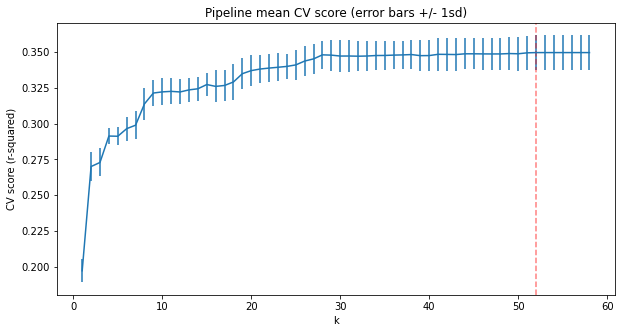

In [826]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [827]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [828]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

neighbourhood_Travis County, Texas, United States       0.626500
neighbourhood_Leander, Texas, United States             0.412654
neighbourhood_Pflugerville, Texas, United States        0.388815
neighbourhood_Austin , Texas, United States             0.343552
neighbourhood_Round Rock, Texas, United States          0.253099
has_availability                                        0.230288
neighbourhood_Cedar Park, Texas, United States          0.215378
neighbourhood_Dripping Springs, Texas, United States    0.199331
neighbourhood_Manor, Austin, Texas, United States       0.125204
neighbourhood_Manchaca, Texas, United States            0.115233
neighbourhood_Lago Vista, Texas, United States          0.105168
has_long term stays allowed                             0.075035
neighbourhood_West Lake Hills, Texas, United States     0.058885
price                                                   0.047201
has_shampoo                                             0.035488
neighbourhood_United Stat

In [844]:
df = get_default_data("modeling_phase.csv")
X, y = default_X_and_y(df)

In [845]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=43)

In [846]:
lasso_model = Lasso()

#create pipeline
pipe_lasso = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    SelectKBest(f_regression),
    lasso_model,
)


Let's look at the pipeline params that we can use to potentially optimize the model with.

In [847]:
pipe_lasso.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'lasso', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'lasso__alpha', 'lasso__copy_X', 'lasso__fit_intercept', 'lasso__max_iter', 'lasso__normalize', 'lasso__positive', 'lasso__precompute', 'lasso__random_state', 'lasso__selection', 'lasso__tol', 'lasso__warm_start'])

Great, now let's optimize the alpha for the regularization of the independent variables for our model as well as the selectKbest to identify the strongest predictors for our target variable.

In [848]:
grid_params = {'lasso__alpha': np.linspace(0, 0.01, 10), 'selectkbest__k': np.arange(0, X_train.shape[1])*1+1}

lasso_grid_cv = GridSearchCV(pipe_lasso, param_grid=grid_params, cv=5, n_jobs=-1)

In [849]:
lasso_grid_cv.fit(X_train, y_train)

/Users/micahforster/Library/Python/3.8/lib/python/site-packages/sklearn/pipeline.py:382: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/micahforster/Library/Python/3.8/lib/python/site-packages/sklearn/pipeline.py:382: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/micahforster/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/micahforster/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x14c8b53a0>)),
                                       ('lasso', Lasso())]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([0.        , 0.00111111, 0.00222222, 0.00333333, 0.00444444,
       0.00555556, 0.00666667, 0.00777778, 0.00888889, 0.01      ]),
                         'selectkbest__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58])})

In [850]:
lasso_grid_cv.best_params_

{'lasso__alpha': 0.0022222222222222222, 'selectkbest__k': 52}

In [851]:
alpha = lasso_grid_cv.best_params_['lasso__alpha']
k_best = lasso_grid_cv.best_params_['selectkbest__k']

In [852]:
lasso_grid_cv.cv_results_['mean_test_score']

array([0.19705426, 0.26994183, 0.27279687, 0.29125991, 0.29112399,
       0.29642672, 0.29885765, 0.31379422, 0.32134517, 0.32215535,
       0.32252119, 0.32210301, 0.32355283, 0.32432559, 0.32728925,
       0.32599994, 0.32665132, 0.32910786, 0.33488856, 0.33704198,
       0.3381433 , 0.33880257, 0.33937368, 0.33997192, 0.34101883,
       0.34371572, 0.34524138, 0.34806984, 0.34785323, 0.34722046,
       0.34724601, 0.34711379, 0.34723768, 0.34758245, 0.34764325,
       0.34785453, 0.34801664, 0.34826392, 0.3482712 , 0.34755125,
       0.34843998, 0.34836899, 0.34826444, 0.34878266, 0.34879493,
       0.34872399, 0.34870087, 0.34871781, 0.3489978 , 0.34889056,
       0.34953143, 0.34970926, 0.34970914, 0.34970914, 0.34970914,
       0.34970914, 0.34970914, 0.34970914, 0.19704353, 0.26992227,
       0.27285306, 0.29123591, 0.29105433, 0.29668054, 0.29935322,
       0.3142778 , 0.32154656, 0.32234658, 0.3226788 , 0.32240377,
       0.32378489, 0.32443359, 0.32711618, 0.32762438, 0.32826

In [853]:
#Let's create the lasso model with the best params that gridsearchcv found for us and test it on our data
lasso_model = Lasso(alpha=alpha)
lasso_pipe141 = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    SelectKBest(f_regression, k=k_best),
    lasso_model
)

In [854]:
lasso_pipe141.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=52,
                             score_func=<function f_regression at 0x14c8b53a0>)),
                ('lasso', Lasso(alpha=0.0022222222222222222))])

In [855]:
notes = f'Lasso regression with {k_best} features based on the GridSearchCV best params along with an alpha of {alpha}'
model_metric_results = get_model_metrics_details(lasso_pipe141, X_train, X_test, y_train, y_test, k_best, f'Lasso Regression k_best Best Features', notes)
model_metric_list.append(model_metric_results)
model_metric_results

{'r2_score_train': 0.35942270510499985,
 'r2_score_test': 0.3682370101985941,
 'mae_score_train': 0.20196782992345036,
 'mae_score_test': 0.19708975657116046,
 'num_features': 52,
 'model_name': 'Lasso Regression k_best Best Features',
 'notes': 'Lasso regression with 52 features based on the GridSearchCV best params along with an alpha of 0.0022222222222222222',
 'model': Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler()),
                 ('selectkbest',
                  SelectKBest(k=52,
                              score_func=<function f_regression at 0x14c8b53a0>)),
                 ('lasso', Lasso(alpha=0.0022222222222222222))])}

Wow!! This is great we improved our r2 score with this regularization method we used for regression. Let's see if we can get even better with Ridge regression.

In [856]:
ridge_model = Ridge()

#create pipeline
pipe_ridge = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    SelectKBest(f_regression),
    ridge_model,
)


In [857]:
pipe_ridge.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'ridge', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'ridge__alpha', 'ridge__copy_X', 'ridge__fit_intercept', 'ridge__max_iter', 'ridge__normalize', 'ridge__positive', 'ridge__random_state', 'ridge__solver', 'ridge__tol'])

In [858]:
grid_params = {'ridge__alpha': np.linspace(0, 0.01, 10), 'selectkbest__k': np.arange(0, X_train.shape[1])*1+1}

ridge_grid_cv = GridSearchCV(pipe_ridge, param_grid=grid_params, cv=5, n_jobs=-1)

In [859]:
ridge_grid_cv.fit(X_train, y_train)

/Users/micahforster/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.92393e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/micahforster/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.0881e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x14c8b53a0>)),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([0.        , 0.00111111, 0.00222222, 0.00333333, 0.00444444,
       0.00555556, 0.00666667, 0.00777778, 0.00888889, 0.01      ]),
                         'selectkbest__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58])})

In [860]:
ridge_grid_cv.best_params_

{'ridge__alpha': 0.01, 'selectkbest__k': 52}

In [861]:
alpha = ridge_grid_cv.best_params_['ridge__alpha']
k_best = ridge_grid_cv.best_params_['selectkbest__k']

In [862]:
ridge_grid_cv.cv_results_['mean_test_score']

array([ 1.97054258e-01,  2.69941832e-01,  2.72796871e-01,  2.91259913e-01,
        2.91123994e-01,  2.96426716e-01,  2.98857646e-01,  3.13794215e-01,
        3.21345166e-01,  3.22155355e-01,  3.22521192e-01,  3.22103014e-01,
        3.23552829e-01,  3.24325593e-01,  3.27289255e-01,  3.25999941e-01,
        3.26651320e-01,  3.29107865e-01,  3.34888559e-01,  3.37041983e-01,
        3.38143296e-01,  3.38802568e-01,  3.39373681e-01,  3.39971919e-01,
        3.41018826e-01,  3.43715723e-01,  3.45241384e-01,  3.48069844e-01,
        3.47853225e-01,  3.47220460e-01,  3.47246006e-01,  3.47113793e-01,
        3.47237676e-01,  3.47582447e-01,  3.47643252e-01,  3.47854530e-01,
        3.48016640e-01,  3.48263924e-01,  3.48271201e-01,  3.47551248e-01,
        3.48439976e-01,  3.48368995e-01,  3.48264441e-01,  3.48782652e-01,
        3.48794929e-01,  3.48724286e-01,  3.48683673e-01,  3.48698004e-01,
        3.48964442e-01, -6.37385354e+23, -6.54323897e+23, -3.66002272e+24,
       -6.66996735e+24, -

In [863]:
#Let's create the ridge model with the best params that gridsearchcv found for us and test it on our data
ridge_model = Ridge(alpha=alpha)
ridge_pipe109 = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    SelectKBest(f_regression, k=k_best),
    ridge_model
)

In [864]:
ridge_pipe109.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=52,
                             score_func=<function f_regression at 0x14c8b53a0>)),
                ('ridge', Ridge(alpha=0.01))])

In [865]:
notes = f'Ridge regression with {k_best} features based on the GridSearchCV best params along with an alpha of {alpha}'
model_metric_results = get_model_metrics_details(ridge_pipe109, X_train, X_test, y_train, y_test, k_best, f'Ridge Regression {k_best} Best Features', notes)
model_metric_list.append(model_metric_results)
model_metric_results

{'r2_score_train': 0.36231153662878623,
 'r2_score_test': 0.3660931021967352,
 'mae_score_train': 0.20115884875123546,
 'mae_score_test': 0.19759774796143642,
 'num_features': 52,
 'model_name': 'Ridge Regression 52 Best Features',
 'notes': 'Ridge regression with 52 features based on the GridSearchCV best params along with an alpha of 0.01',
 'model': Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler()),
                 ('selectkbest',
                  SelectKBest(k=52,
                              score_func=<function f_regression at 0x14c8b53a0>)),
                 ('ridge', Ridge(alpha=0.01))])}

When comparing the various models (LinearRegression, Lasso and Ridge) it appears that Ridge is the slight favorite.

In [1]:
model_metric_list


KeyboardInterrupt



In [867]:
best_model = ridge_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [870]:
output = open('airbnb_regression_model.pkl', 'wb')
pickle.dump(best_model, output)
output.close()

# Conclusion

Althought the r2 score is not at .9 this is understandable given the nature of the problem that we are trying to solve with regression. In fact for problems related to social sciences domain an r2 score close to .5 is actually pretty good.

# Recommendations

This model main purpose is to predict the booking percentage of an airbnb property in Austin, TX. However, there are additional things that can be noted for future developments such as the following:

* Swtiching the objective from a linear regression to a logistic regression solution to be able to do a binary classification of whether or not a listing will book 50% or more

* Further investigate potential multicollinearilty in the independent features that may be causing an uncessary sensitivty to variance in the data

* Find additional data sources that can further augment the current dataset and improve model predictive power